<a href="https://colab.research.google.com/github/sayanbanerjee32/keyword_search/blob/main/Smart_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a super smart search engine over any free text data source

This code acompanies the following blog posts by https://medium.com/@thejoshtaylor


In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time
from google.colab import drive

# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


     |████████████████████████████████| 188 kB 3.2 MB/s 
     |████████████████████████████████| 171 kB 20.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Skipping wheel build for nmslib, due to binaries being disabled for it.
  Created wheel for pybind11: filename=pybind11-2.6.1-py2.py3-none-any.whl size=188544 sha256=26ed83609ca8fcef2bf297b3fd630bacd377147e199d9ff054298ed0af2958e7
  Stored in directory: /root/.cache/pip/wheels/8b/b3/81/fca95a2eb5f25e99520a9439b905a79fe4ec1c7f56bddfff0c
Successfully built pybind11
    Running setup.py install for nmslib ... done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
!gdown --id 13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ

Downloading...
From: https://drive.google.com/uc?id=13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ
To: /content/export.csv
145MB [00:01, 132MB/s] 


### Load data and create DF

In [3]:
#LINK TO DATASET USED:
# https://drive.google.com/file/d/13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ/view?usp=sharing

import pandas as pd
df = pd.read_csv('export.csv')
df['text'] = df['tendertitle'] + ' ' + df['tenderdescription']+ ' ' + df['locality']+ ' ' + df['postalCode']
df.shape


(212447, 6)

In [4]:
df.head(1)

,externalid,tendertitle,tenderdescription,locality,postalCode,text
0,00227ecd-50ac-4f92-9e7f-d2675663efa2,TELEPHONY SERVICES,TELEPHONY SERVICES,Exeter,EX1 3PB,TELEPHONY SERVICES TELEPHONY SERVICES Exeter EX1 3PB


### Preprocess and tokenise

In [7]:
nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
# text = [fix_text(str(i)) for i in text]
text = [str(i) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


212447it [02:02, 1727.23it/s]


### Fast text

In [ ]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

### Load fasttext and query

In [ ]:
ft_model = FastText.load('_fasttext.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


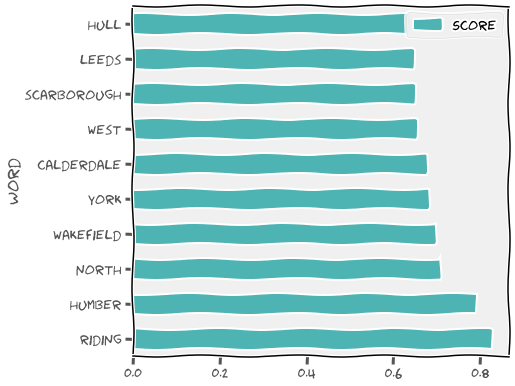

In [ ]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("yorkshire", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


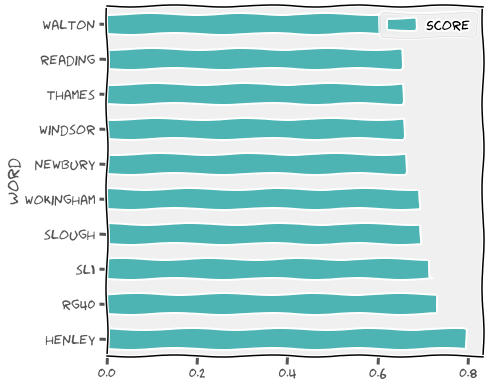

In [ ]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("rg9", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [ ]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    vector = ft_model[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

In [ ]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

### Load document vectors, build index and search:

In [ ]:
with open( "weighted_doc_vects.p", "rb" ) as f:
  weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [ ]:
# querying the index:
input = 'audit services Norwic'.lower().split()


query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 212447 records in 0.0005 seconds 

0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.11
GB-NORWICH: EXTERNAL AUDIT ANNUAL AUDIT OF TRUST FINANCIAL & QUALITY ACCOUNTS AND ANNUAL REPORT. Norwich NR6 5BE
0.12
GB-NORWICH: 18-022 - INTERNAL AUDIT SERVICES BROADLAND HOUSING GROUP WISHES TO ENTER INTO A CONTRACT FOR INTERNAL AUDITING. Norwich NR1 1HU
0.13
PROVISION OF AUDIT AND CONSULTANCY AUDIT SERVICES - EXTERNAL AUDIT SERVICES THIS NOTICE IS FOR THE AWARD FOLLOWING MINI COMPETITION TO GRANT THORNTON LLP OF A CONTRACT FOR THE PROVISION OF EXTERNAL AUDIT AND AUDIT CONSULTANCY SERVICES TO THE TRUST. London SW17 0QT
0.13
PURCON637 INTERNAL AUD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
